<a href="https://colab.research.google.com/github/jahnavi-maddhuri/bny-ai-risk-management/blob/for-pres/NeuralNetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data  Load + Preparation
Convert article data into matrices of embedded articles, each representing one day. I will use FinBERT to embed each article.

In [2]:
import pandas as pd

from transformers import AutoModel, AutoTokenizer

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [3]:
# load data from github
price_change = pd.read_csv('https://raw.githubusercontent.com/jahnavi-maddhuri/\
bny-ai-risk-management/refs/heads/for-pres/data/BNY_stock_change2025.csv')[[
    'Date', 'Change %']]
articles = pd.read_csv('https://raw.githubusercontent.com/jahnavi-maddhuri/\
bny-ai-risk-management/refs/heads/for-pres/data/gnews_multi_day/\
2025-04-01--TO--2025-04-30.csv')[['published_dt', 'full_text']]
# articles.head()

# change col names/dtypes
price_change.rename(columns={'Change %':'change', 'Date': 'date'}, inplace=True)
price_change['change'] = price_change['change'].str.replace('%',
                                                            '').astype(float)
price_change['date'] = pd.to_datetime(price_change['date'], format='%m/%d/%Y')

articles.rename(columns={'published_dt': 'date'}, inplace=True)
articles['date'] = pd.to_datetime(articles['date'])

In [4]:
print(f'Price change successfully loaded with columns: {price_change.columns}')
print(f'\tPrice change shape: {price_change.shape}')
print(f'Articles successfully loaded with columns: {articles.columns}')
print(f'\tArticles shape: {articles.shape}')

Price change successfully loaded with columns: Index(['date', 'change'], dtype='object')
	Price change shape: (513, 2)
Articles successfully loaded with columns: Index(['date', 'full_text'], dtype='object')
	Articles shape: (137, 2)


In [5]:
df = articles.merge(price_change, on='date', how='left')
# drop weekend days for now - merge texts later
df = df.dropna(subset=['change'])
df = df.sort_values('date')

In [6]:
tokenizer = AutoTokenizer.from_pretrained('ProsusAI/finbert')

def prepare_data(df, max_articles=20, max_length=512):
    """
    df: DataFrame with columns ['date', 'full_text']
    price_change: DataFrame with columns ['date', 'stock_price_change']
    """
    # Group articles by date
    grouped = df.groupby('date')

    X_tokens = []
    X_masks = []
    y = []

    for date, group in grouped:
        articles_text = group['full_text'].tolist()[:max_articles]

        # Pad if fewer than max_articles
        while len(articles_text) < max_articles:
            articles_text.append("")  # Empty articles will be masked

        # Tokenize all articles for this day
        encoded = tokenizer(
            articles_text,
            padding='max_length',
            truncation=True,
            max_length=max_length,
            return_tensors='pt'
        )

        X_tokens.append(encoded['input_ids'])
        X_masks.append(encoded['attention_mask'])
        y.append(group['change'].iloc[0])

    return torch.stack(X_tokens), torch.stack(X_masks), torch.tensor(y)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [7]:
X_tokens, X_masks, y = prepare_data(df)

## Define NN

In [8]:
class Model(nn.Module):
    def __init__(self, hidden_dim=768, num_heads=8, dropout=0.1):
        super().__init__()

        # 1. FinBERT for embedding articles
        self.finbert = AutoModel.from_pretrained('ProsusAI/finbert')

        # Freeze FinBERT if you want (or fine-tune it)
        for param in self.finbert.parameters():
            param.requires_grad = False

        # 2. Self-attention to weigh importance of different articles
        self.attention = nn.MultiheadAttention(
            embed_dim=hidden_dim,
            num_heads=num_heads,
            dropout=dropout,
            batch_first=True
        )

        # 3. Layer normalization
        self.layer_norm = nn.LayerNorm(hidden_dim)

        # 4. Aggregation layer (combines multiple article embeddings)
        self.aggregation = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        # 5. Final prediction layers
        # FIXED: Input size should be hidden_dim // 2 = 384, not 256
        self.predictor = nn.Sequential(
            nn.Linear(hidden_dim // 2, 128),  # Changed from 256 to hidden_dim // 2
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 1)  # Predict price change
        )

    def forward(self, article_tokens, attention_masks, additional_features=None):
        """
        article_tokens: [batch_size, num_articles, seq_len]
        attention_masks: [batch_size, num_articles, seq_len]
        additional_features: [batch_size, num_features] - optional (not used in this version)
        """
        batch_size, num_articles, seq_len = article_tokens.shape

        # 1. Embed each article with FinBERT
        article_tokens_flat = article_tokens.view(-1, seq_len)
        attention_masks_flat = attention_masks.view(-1, seq_len)

        with torch.no_grad():
            outputs = self.finbert(
                input_ids=article_tokens_flat,
                attention_mask=attention_masks_flat
            )

        # Use [CLS] token embedding for each article
        article_embeddings = outputs.last_hidden_state[:, 0, :]
        article_embeddings = article_embeddings.view(batch_size, num_articles, -1)

        # 2. Apply self-attention across articles
        attended_embeddings, attention_weights = self.attention(
            article_embeddings,
            article_embeddings,
            article_embeddings
        )

        # 3. Layer norm and residual connection
        attended_embeddings = self.layer_norm(attended_embeddings + article_embeddings)

        # 4. Aggregate articles (mean pooling)
        aggregated = torch.mean(attended_embeddings, dim=1)  # [batch_size, hidden_dim]

        # 5. Pass through aggregation layer
        aggregated = self.aggregation(aggregated)  # [batch_size, hidden_dim//2] = [batch_size, 384]

        # 6. Final prediction
        price_change = self.predictor(aggregated)  # Now expects [batch_size, 384]

        return price_change, attention_weights

## Train NN

In [9]:
# Split Train/Test 21/10 temporal split
TRAIN_DAYS = 15
TEST_DAYS = 7

# Make sure data is sorted by date first!

X_train_tokens = X_tokens[:TRAIN_DAYS]
X_train_masks = X_masks[:TRAIN_DAYS]
y_train = y[:TRAIN_DAYS]

X_test_tokens = X_tokens[TRAIN_DAYS:]
X_test_masks = X_masks[TRAIN_DAYS:]
y_test = y[TRAIN_DAYS:]

print(f"Training on {len(y_train)} days")
print(f"Testing on {len(y_test)} days")

Training on 15 days
Testing on 7 days


In [13]:
import time

In [15]:
# Create datasets
train_dataset = TensorDataset(X_train_tokens, X_train_masks, y_train)
test_dataset = TensorDataset(X_test_tokens, X_test_masks, y_test)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=False)  # shuffle=False for time series
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

# Initialize model
model = Model()
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

# Training loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

for epoch in range(20):
  start_time = time.time()
  model.train()
  train_loss = 0

  for tokens, masks, targets in train_loader:
      # Move ALL data to GPU BEFORE forward pass
      tokens = tokens.to(device)
      masks = masks.to(device)
      targets = targets.to(device)

      optimizer.zero_grad()
      predictions, _ = model(tokens, masks)
      loss = criterion(predictions.squeeze(), targets.float())
      loss.backward()
      optimizer.step()
      train_loss += loss.item()

  # Validation
  model.eval()
  test_loss = 0
  with torch.no_grad():
      for tokens, masks, targets in test_loader:
          # Move ALL data to GPU BEFORE forward pass
          tokens = tokens.to(device)
          masks = masks.to(device)
          targets = targets.to(device)

          predictions, _ = model(tokens, masks)
          loss = criterion(predictions.squeeze(), targets.float())
          test_loss += loss.item()

  epoch_time = time.time() - start_time
  print(f"Epoch {epoch+1} - Time: {epoch_time:.2f}s")
  print(f"  Train Loss: {train_loss/len(train_loader):.4f}")
  print(f"  Test Loss: {test_loss/len(test_loader):.4f}")

Epoch 1 - Time: 11.97s
  Train Loss: 12.9235
  Test Loss: 1.3029
Epoch 2 - Time: 12.28s
  Train Loss: 12.8059
  Test Loss: 1.3610
Epoch 3 - Time: 12.64s
  Train Loss: 12.7380
  Test Loss: 1.4654
Epoch 4 - Time: 12.72s
  Train Loss: 12.7561
  Test Loss: 1.5436
Epoch 5 - Time: 12.44s
  Train Loss: 12.7151
  Test Loss: 1.5932
Epoch 6 - Time: 12.23s
  Train Loss: 12.7027
  Test Loss: 1.6017
Epoch 7 - Time: 12.14s
  Train Loss: 12.6232
  Test Loss: 1.5881
Epoch 8 - Time: 12.15s
  Train Loss: 12.4751
  Test Loss: 1.5829
Epoch 9 - Time: 12.24s
  Train Loss: 12.3242
  Test Loss: 1.5768
Epoch 10 - Time: 12.36s
  Train Loss: 12.2777
  Test Loss: 1.5542
Epoch 11 - Time: 12.38s
  Train Loss: 12.0718
  Test Loss: 1.5811
Epoch 12 - Time: 12.32s
  Train Loss: 11.9059
  Test Loss: 1.6391
Epoch 13 - Time: 12.30s
  Train Loss: 11.7758
  Test Loss: 1.7573
Epoch 14 - Time: 12.29s
  Train Loss: 11.4081
  Test Loss: 1.9251
Epoch 15 - Time: 12.29s
  Train Loss: 11.1904
  Test Loss: 2.1551
Epoch 16 - Time: 12

# Analyze model performance

In [16]:
# Set model to evaluation mode
model.eval()

# Get predictions on test set
predictions = []
actuals = []

with torch.no_grad():
    for tokens, masks, targets in test_loader:
        tokens = tokens.to(device)
        masks = masks.to(device)

        preds, _ = model(tokens, masks)
        predictions.extend(preds.squeeze().cpu().numpy())
        actuals.extend(targets.numpy())

# Convert to numpy arrays
predictions = np.array(predictions)
actuals = np.array(actuals)

# Display predicted vs actual
print("Predicted vs Actual Price Changes:")
print("=" * 50)
print(f"{'Day':<6} {'Actual':<12} {'Predicted':<12} {'Error':<12}")
print("=" * 50)
for i, (actual, pred) in enumerate(zip(actuals, predictions)):
    error = actual - pred
    print(f"{i+1:<6} {actual:>11.2f}% {pred:>11.2f}% {error:>11.2f}%")
print("=" * 50)

Predicted vs Actual Price Changes:
Day    Actual       Predicted    Error       
1             1.86%        0.63%        1.23%
2             1.27%       -0.58%        1.85%
3            -0.09%       -2.63%        2.54%
4             0.33%        0.62%       -0.29%
5             1.43%       -1.47%        2.90%
6             0.46%       -1.32%        1.78%
7             0.62%        0.64%       -0.02%


MODEL EVALUATION METRICS
Mean Squared Error (MSE):     3.3002
Root Mean Squared Error (RMSE): 1.8166
Mean Absolute Error (MAE):    1.5173
R² Score:                     -6.9901
Direction Accuracy:           57.14%


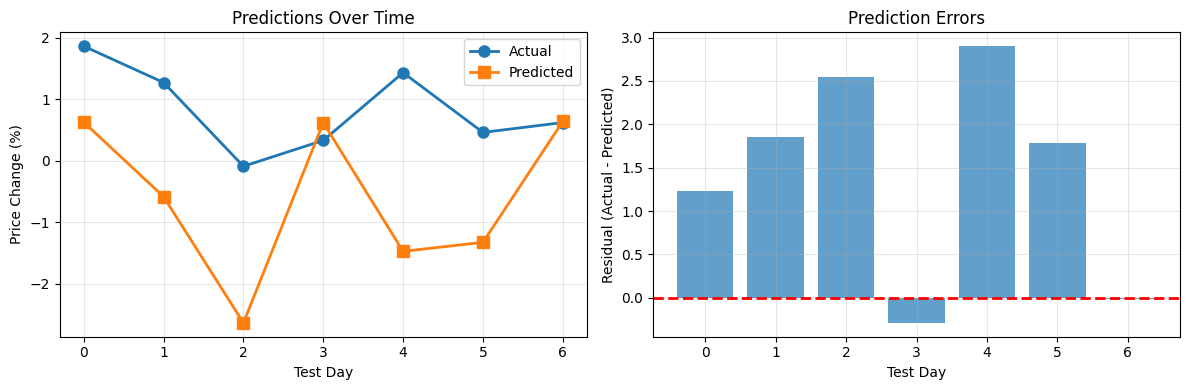

In [22]:
# Calculate metrics
mse = mean_squared_error(actuals, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actuals, predictions)
r2 = r2_score(actuals, predictions)

# Direction accuracy (did we predict the right direction?)
pred_direction = np.sign(predictions)
actual_direction = np.sign(actuals)
direction_accuracy = np.mean(pred_direction == actual_direction) * 100

print("=" * 50)
print("MODEL EVALUATION METRICS")
print("=" * 50)
print(f"Mean Squared Error (MSE):     {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE):    {mae:.4f}")
print(f"R² Score:                     {r2:.4f}")
print(f"Direction Accuracy:           {direction_accuracy:.2f}%")
print("=" * 50)

plt.figure(figsize=(12, 4))
# Visualization 2: Time Series Plot
# plt.subplot(1, 3, 2)
plt.subplot(1, 2, 1)
days = np.arange(len(actuals))
plt.plot(days, actuals, 'o-', label='Actual', linewidth=2, markersize=8)
plt.plot(days, predictions, 's-', label='Predicted', linewidth=2, markersize=8)
plt.xlabel('Test Day')
plt.ylabel('Price Change (%)')
plt.title('Predictions Over Time')
plt.legend()
plt.grid(True, alpha=0.3)

# Visualization 3: Residuals (Prediction Errors)
# plt.subplot(1, 3, 3)
plt.subplot(1, 2, 2)
residuals = actuals - predictions
plt.bar(days, residuals, alpha=0.7)
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.xlabel('Test Day')
plt.ylabel('Residual (Actual - Predicted)')
plt.title('Prediction Errors')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()